# EE 660 - Fall 2017 - Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("../../input/housing2.csv", parse_dates=True, sep=',')

In [3]:
df.columns

Index(['Listing Office - Office Name', 'List Agent - Agent Name', 'Price',
       'Status', 'Address', 'City', 'MLS #', 'Property Type', 'State',
       'County', 'Date - MLS List', 'Bedrooms - Total', 'Baths - Total',
       'SqFtTotFn', 'DOM', 'Assessment Amount', 'Assessment Year',
       'Price - Closed', 'Price - List', 'PicCount', ' Price - Original ',
       ' Tax - Gross Amount ', 'Date - Closed', 'Lot - Acres', 'Garage Type',
       'Year Built', 'Total Stories', 'Surveyed', 'Showing Service',
       'Seasonal', 'Water Body Type', 'Water Frontage Length', 'Short Sale',
       'Rooms - Total', 'Rented', 'Garage Capacity', 'Garage',
       'Foreclosed/Bank-Owned/REO', 'Flood Zone', 'Easements',
       'Development / Subdivision', 'Current Use', 'Covenants',
       'Common Land Acres', 'Basement Access Type', 'Basement'],
      dtype='object')

# Clean up data, remove data and features

In [4]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing_data.head(20)

,Total,Percent Missing
Rented,5947,0.988038
Showing Service,5869,0.975079
Easements,5695,0.946170
Common Land Acres,5661,0.940522
Water Frontage Length,5465,0.907958
Water Body Type,5099,0.847151
Development / Subdivision,4787,0.795315
Assessment Year,3902,0.648280
Current Use,3331,0.553414
Assessment Amount,3036,0.504403


In [5]:
# remove because there are too many missing data in the feature
del df['Rented']
del df['Showing Service']
del df['Easements']
del df['Common Land Acres']
del df['Water Frontage Length']
del df['Water Body Type']
del df['Development / Subdivision']
del df['Assessment Year']
del df['Current Use']
del df['Assessment Amount']
del df['Short Sale']
del df['Garage Type']
del df['Basement Access Type']
del df['Foreclosed/Bank-Owned/REO']

# remove because data is irrelevant or duplicate
del df['MLS #']
del df['Status']
del df['Price - Closed'] # same as feature 'Price'
del df['Price - List']
del df[' Price - Original ']
del df[' Tax - Gross Amount '] # sale price determines Taxes, not the othe way around
del df['Seasonal'] # whether or not a property is seasonal (summer home) should not change the outlook of a buyer 

# remove due to feature set size being too big
del df['Listing Office - Office Name']
del df['List Agent - Agent Name']

# remove due to redundancy
del df['Address']
del df['State']
del df['County']

In [6]:
df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)
df['SqFtTotFn'] = df['SqFtTotFn'].str.replace(',', '')
df['SqFtTotFn'] = df['SqFtTotFn'].astype(float)

In [7]:
# Enrich garage and garage capacity features
# 1. If garage == no, then add 0 to garage capacity, i.e. make sure garage capacity = 0
df['Garage Capacity'].replace('', np.nan, inplace=True)
df['Garage'].replace('', np.nan, inplace=True)
df.loc[df['Garage'] == 'No', 'Garage Capacity'] = 0
del df['Garage']

In [8]:
# Change Basement from Yes/No to 1/0
df.Basement = pd.Series(np.where(df.Basement.values == 'Yes', 1, 0), df.index)

In [9]:
# Total Stories contains 4+ values that we will set to 4 
stories = lambda x: '4' if x == '4+' else x
df['Total Stories'] = df['Total Stories'].apply(stories)
df['Total Stories'] = df['Total Stories'].astype(float)

In [10]:
# Create the Days in market metric which is the date of closure - date of MLS listing
# some weird error accessing df['Date - Closed']
closed = df.columns.get_loc("Date - Closed")
listed = df.columns.get_loc("Date - MLS List")
df.DaysMkt = pd.to_datetime(df[df.columns[closed]]) - pd.to_datetime(df[df.columns[listed]])
df = df.drop('Date - Closed', 1)
df = df.drop('Date - MLS List', 1)

In [11]:
# BEFORE: remove samples missing certain features
print(df.isnull().sum().sum())
print(len(df))
df.isnull().sum()

75
6019


Price                0
City                 0
Property Type        0
Bedrooms - Total     0
Baths - Total        0
SqFtTotFn            2
DOM                  0
PicCount             0
Lot - Acres         51
Year Built           5
Total Stories        1
Surveyed             7
Rooms - Total        0
Garage Capacity      5
Flood Zone           2
Covenants            2
Basement             0
dtype: int64

In [12]:
# AFTER: remove samples any missing features
df.dropna(how='any', inplace = True)
print(df.isnull().sum().sum())
print(len(df))
df.isnull().sum()

0
5950


Price               0
City                0
Property Type       0
Bedrooms - Total    0
Baths - Total       0
SqFtTotFn           0
DOM                 0
PicCount            0
Lot - Acres         0
Year Built          0
Total Stories       0
Surveyed            0
Rooms - Total       0
Garage Capacity     0
Flood Zone          0
Covenants           0
Basement            0
dtype: int64

In [13]:
# make y = df.Price and x = df
labels = df.Price
del df['Price']

# Split the set into pre-training, training, validation and test set

In [14]:
# Perform the pre-train, train, validation and test split
from sklearn.model_selection import train_test_split
x, x_pre, labels, y_pre = train_test_split(df, labels, test_size=500)
x_train, x, y_train, labels = train_test_split(x, labels, train_size =0.7, test_size = 0.3)
x_test, x_cv, y_test, y_cv = train_test_split(x, labels, train_size =0.5, test_size = 0.5)
print(len(x_pre), len(y_pre))
#print(len(x), len(labels))
print(len(x_train), len(y_train))
print(len(x_cv), len(y_cv))
print(len(x_test), len(y_test))
print(x_train.index)

500 500
3814 3814
818 818
817 817
Int64Index([2105, 5881, 2689, 1141, 1924, 4129, 2759,   21, 4468, 4388,
            ...
            1113, 3752, 2846, 2245, 3756, 1947, 2504, 4396, 5909, 2634],
           dtype='int64', length=3814)


# Analyze x_pre for the categorical features to keep

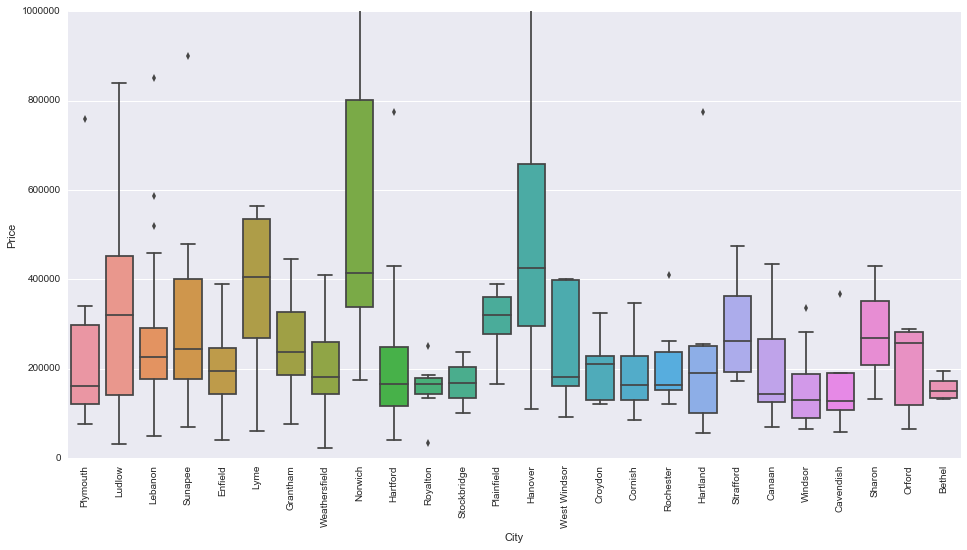

In [16]:
var = 'City'
data = pd.concat([y_pre, x_pre[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=1000000);
plt.xticks(rotation=90);

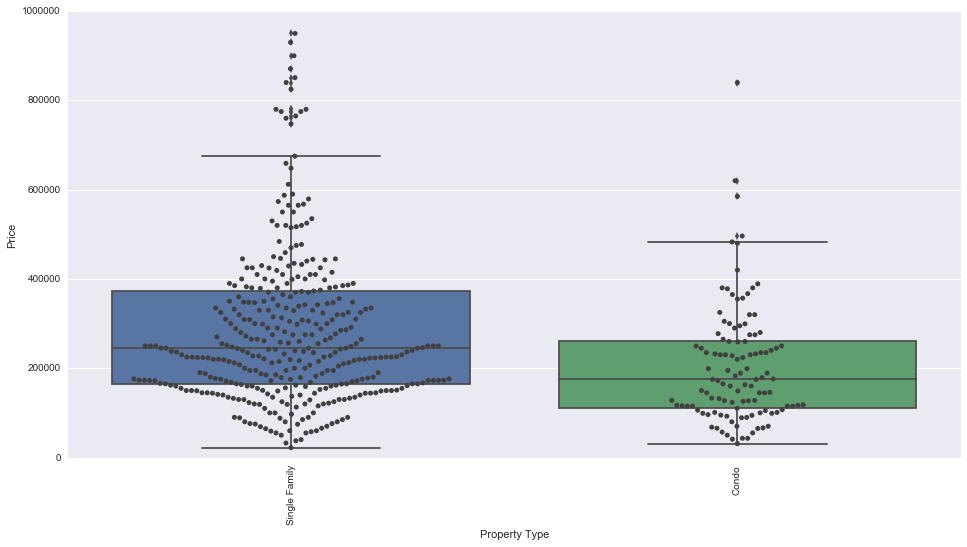

In [17]:
var = 'Property Type'
data = pd.concat([y_pre, x_pre[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig = sns.swarmplot(x=var, y="Price", data=data, color=".25")
fig.axis(ymin=0, ymax=1000000);
plt.xticks(rotation=90);
#1=single family, 0=condo

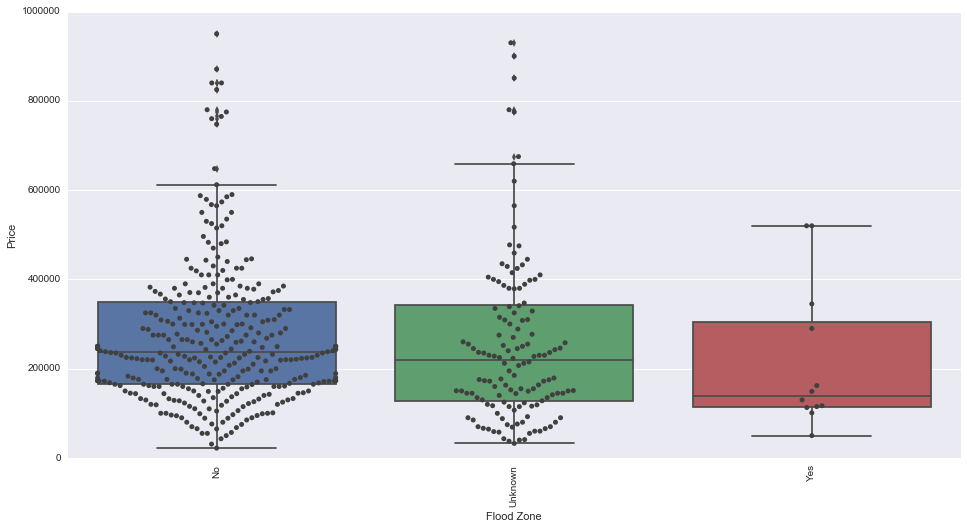

In [18]:
var = 'Flood Zone'
data = pd.concat([y_pre, x_pre[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig = sns.swarmplot(x=var, y="Price", data=data, color=".25")
fig.axis(ymin=0, ymax=1000000);
plt.xticks(rotation=90);
# Interesting that you get very different results in different runs

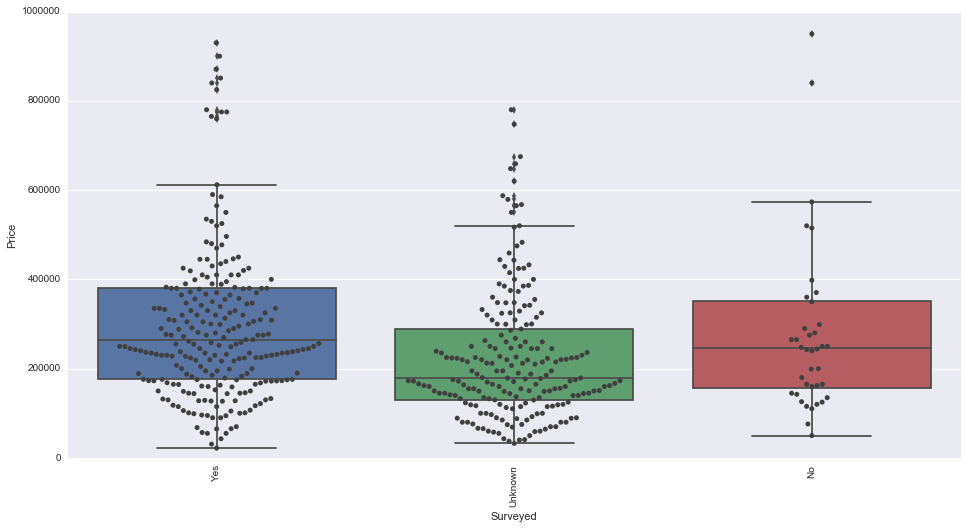

In [19]:
var = 'Surveyed'
data = pd.concat([y_pre, x_pre[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig = sns.swarmplot(x=var, y="Price", data=data, color=".25")
fig.axis(ymin=0, ymax=1000000);
plt.xticks(rotation=90);
#one hot

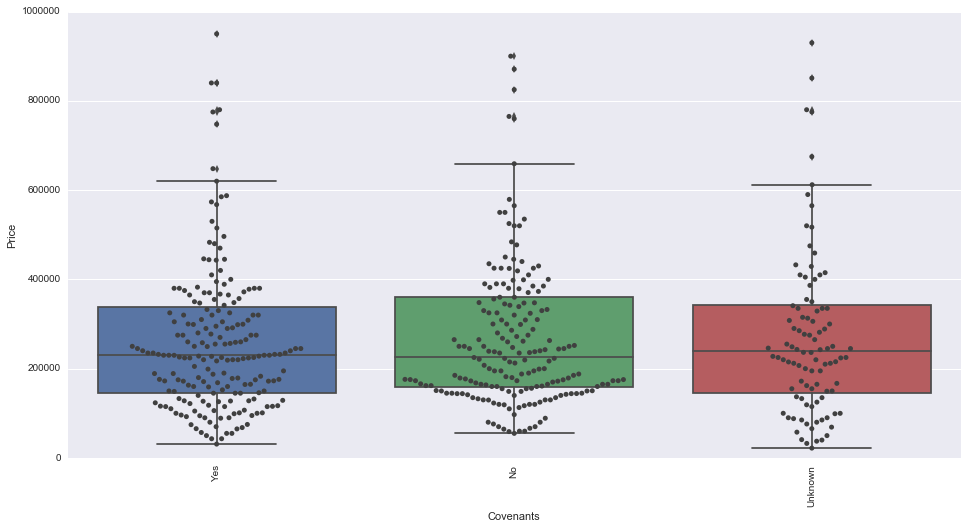

In [20]:
var = 'Covenants'
data = pd.concat([y_pre, x_pre[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig = sns.swarmplot(x=var, y="Price", data=data, color=".25")
fig.axis(ymin=0, ymax=1000000);
plt.xticks(rotation=90);

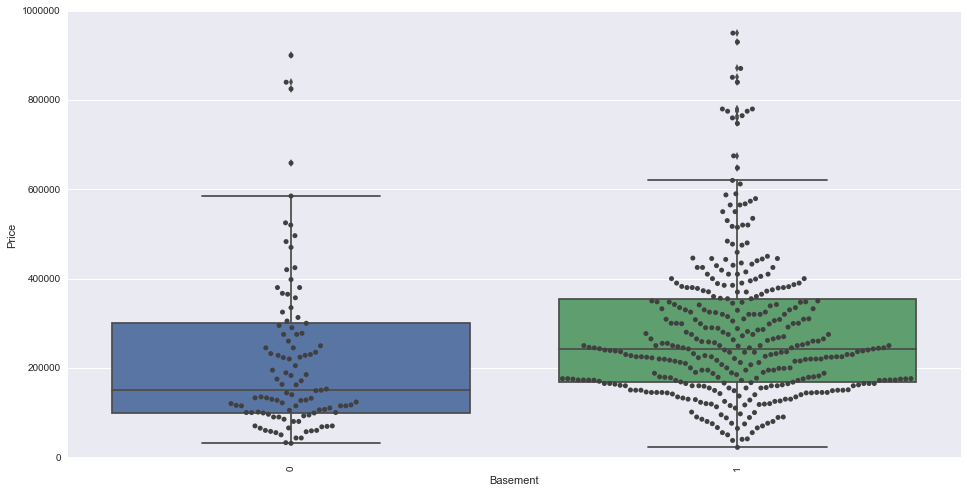

In [21]:
var = 'Basement'
data = pd.concat([y_pre, x_pre[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig = sns.swarmplot(x=var, y="Price", data=data, color=".25")
fig.axis(ymin=0, ymax=1000000);
plt.xticks(rotation=90);
#1=yes, 0=no

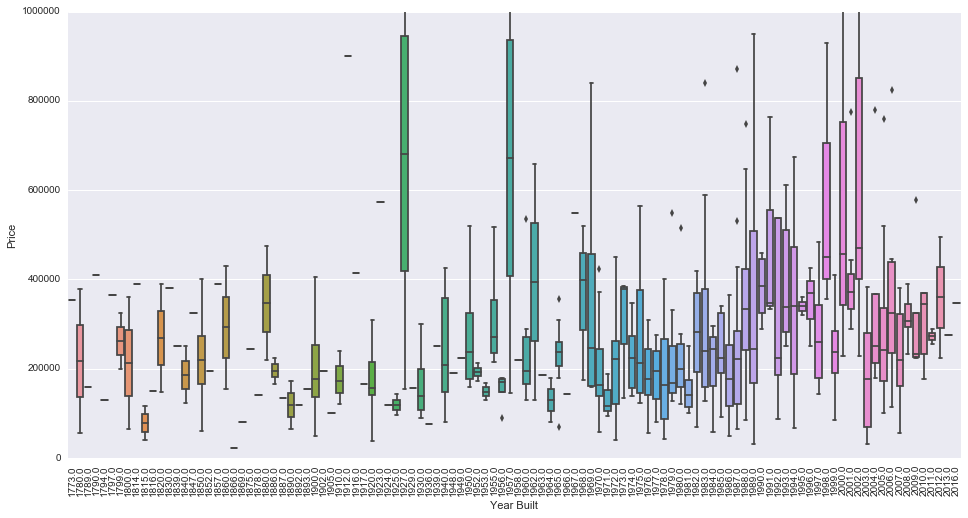

In [22]:
var = 'Year Built'
data = pd.concat([y_pre, x_pre[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=1000000);
plt.xticks(rotation=90);

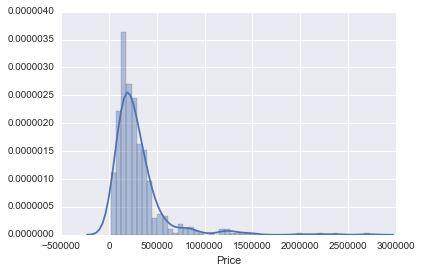

In [23]:
#histogram
sns.distplot(y_pre);

# One hot encode features

In [24]:
#https://www.dataquest.io/blog/machine-learning-python/

In [16]:
# How many unique values in certain fields are there
len(df.City.unique())

26

In [17]:
# One hot encode some features. Need to do this on all three data sets
x_train = pd.concat([x_train, 
           pd.get_dummies(x_train[['Property Type']]),
           pd.get_dummies(x_train[['Flood Zone']]),
           pd.get_dummies(x_train[['Surveyed']]),
           pd.get_dummies(x_train[['Covenants']]),
           pd.get_dummies(x_train[['City']])], axis=1)
x_train.drop(['City','Property Type','Flood Zone','Surveyed','Covenants'], axis=1, inplace=True)

x_cv = pd.concat([x_cv, 
           pd.get_dummies(x_cv[['Property Type']]),
           pd.get_dummies(x_cv[['Flood Zone']]),
           pd.get_dummies(x_cv[['Surveyed']]),
           pd.get_dummies(x_cv[['Covenants']]),
           pd.get_dummies(x_cv[['City']])], axis=1)
x_cv.drop(['City','Property Type','Flood Zone','Surveyed','Covenants'], axis=1, inplace=True)

x_test = pd.concat([x_test, 
           pd.get_dummies(x_test[['Property Type']]),
           pd.get_dummies(x_test[['Flood Zone']]),
           pd.get_dummies(x_test[['Surveyed']]),
           pd.get_dummies(x_test[['Covenants']]),
           pd.get_dummies(x_test[['City']])], axis=1)
x_test.drop(['City','Property Type','Flood Zone','Surveyed','Covenants'], axis=1, inplace=True)

In [27]:
print(x_train.columns)
print(x_cv.columns)
print(x_test.columns)

Index(['Bedrooms - Total', 'Baths - Total', 'SqFtTotFn', 'DOM', 'PicCount',
       'Lot - Acres', 'Year Built', 'Total Stories', 'Rooms - Total',
       'Garage Capacity', 'Basement', 'Property Type_Condo',
       'Property Type_Single Family', 'Flood Zone_No', 'Flood Zone_Unknown',
       'Flood Zone_Yes', 'Surveyed_No', 'Surveyed_Unknown', 'Surveyed_Yes',
       'Covenants_No', 'Covenants_Unknown', 'Covenants_Yes', 'City_Bethel',
       'City_Canaan', 'City_Cavendish', 'City_Cornish', 'City_Croydon',
       'City_Enfield', 'City_Grantham', 'City_Hanover', 'City_Hartford',
       'City_Hartland', 'City_Lebanon', 'City_Ludlow', 'City_Lyme',
       'City_Norwich', 'City_Orford', 'City_Plainfield', 'City_Plymouth',
       'City_Rochester', 'City_Royalton', 'City_Sharon', 'City_Stockbridge',
       'City_Strafford', 'City_Sunapee', 'City_Weathersfield',
       'City_West Windsor', 'City_Windsor'],
      dtype='object')
Index(['Bedrooms - Total', 'Baths - Total', 'SqFtTotFn', 'DOM', 'PicCo

## Feature Selection
1. normalization
2. feature extration: group year built by decade
https://datasciencedojo.com/predicting-value-house/
3. stanford paper on this exercise
https://web.stanford.edu/class/cs221/2017/restricted/p-final/ianjones/final.pdf

Citations (in addition to the above)
http://scikit-learn.org/stable/about.html#citing-scikit-learn

In [31]:
#http://scikit-learn.org/stable/modules/feature_selection.html
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
x_train.shape  

(3814, 48)

In [32]:
clf = ExtraTreesClassifier()
clf = clf.fit(x_train, y_train)
clf.feature_importances_

array([ 0.04674145,  0.04646808,  0.09428792,  0.10890689,  0.09889043,
        0.07755725,  0.08755786,  0.05314492,  0.07444621,  0.04047528,
        0.01591095,  0.00335488,  0.00331696,  0.01316515,  0.01279843,
        0.00372568,  0.01036232,  0.02014497,  0.01920776,  0.01375948,
        0.01400154,  0.01367441,  0.0035744 ,  0.00629273,  0.00364125,
        0.00395433,  0.00179194,  0.00620063,  0.00789895,  0.00465865,
        0.01310424,  0.00496243,  0.01212523,  0.00834491,  0.00336387,
        0.00497852,  0.00270454,  0.00369693,  0.00441808,  0.00292275,
        0.00334432,  0.00234562,  0.00227919,  0.00196246,  0.00878215,
        0.0046249 ,  0.00275579,  0.0033724 ])

In [33]:
model = SelectFromModel(clf, prefit=True, threshold=0.01)
x_train_new = model.transform(x_train)
x_cv_new = model.transform(x_cv)
x_test_new = model.transform(x_test)

x_train_new.shape

(3814, 21)

### Start ML
1. Regression
2. regression with reg (l2, l1, l0)
3. decision tree
4. boost
5. logistig

In [34]:
from sklearn import linear_model
# Create linear regression object
linear = linear_model.LinearRegression()

# use all of the features
linear.fit(x_train, y_train)
print(linear.score(x_train, y_train))
#Equation coefficient and Intercept
print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)
#Predict Output
linear_predicted_full = linear.predict(x_test)
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
linear_predicted_full_df = pd.DataFrame(data=linear.predict(x_test), columns=['Price'], index=x_test.index)

linear = linear_model.LinearRegression()
# Train the model using the training sets and check score
linear.fit(x_train_new, y_train)
print(linear.score(x_train_new, y_train))
#Equation coefficient and Intercept
print('Coefficient: \n', linear.coef_)
print('Intercept: \n', linear.intercept_)
#Predict Output
linear_predicted_lean= linear.predict(x_test_new)

#VERY IMPORTANT TO KEEP THE INDEX!!!!!
linear_predicted_lean_df = pd.DataFrame(data=linear.predict(x_test_new), columns=['Price'], index=x_test.index)

0.526335013662
Coefficient: 
 [  6.49274299e+03   3.72109922e+04   1.16739181e+02  -2.21460138e+01
   2.60392999e+03   9.52830236e+02   2.40697983e+02  -3.05611696e+03
  -7.84692834e+02   5.41452040e+03  -4.48291556e+04  -1.78537027e+04
   1.78537027e+04   1.88006575e+03   8.51067043e+02  -2.73113280e+03
   2.47454276e+04  -2.05567676e+04  -4.18866002e+03   1.30250121e+04
  -8.36343249e+03  -4.66157963e+03  -7.74748105e+04  -5.07894823e+04
  -5.72258332e+04  -2.21246930e+04  -4.60182368e+04  -5.15564020e+03
  -5.75488591e+04   2.05743860e+05  -3.06920417e+04   3.43171932e+04
   1.16902948e+04   9.73791095e+04   1.63713208e+05   1.27188496e+05
  -6.65260253e+03  -4.36670136e+04  -3.41513237e+04  -1.06668002e+05
  -6.48308823e+04  -4.37922243e+03  -7.13233519e+04  -3.22697771e+04
   2.22701504e+05  -5.34538551e+04  -4.30861903e+04  -5.52218477e+04]
Intercept: 
 -562306.990258
0.42590119732
Coefficient: 
 [  6.93173164e+03   4.59797917e+04   1.27553272e+02  -4.77396900e+01
   2.06548440e+

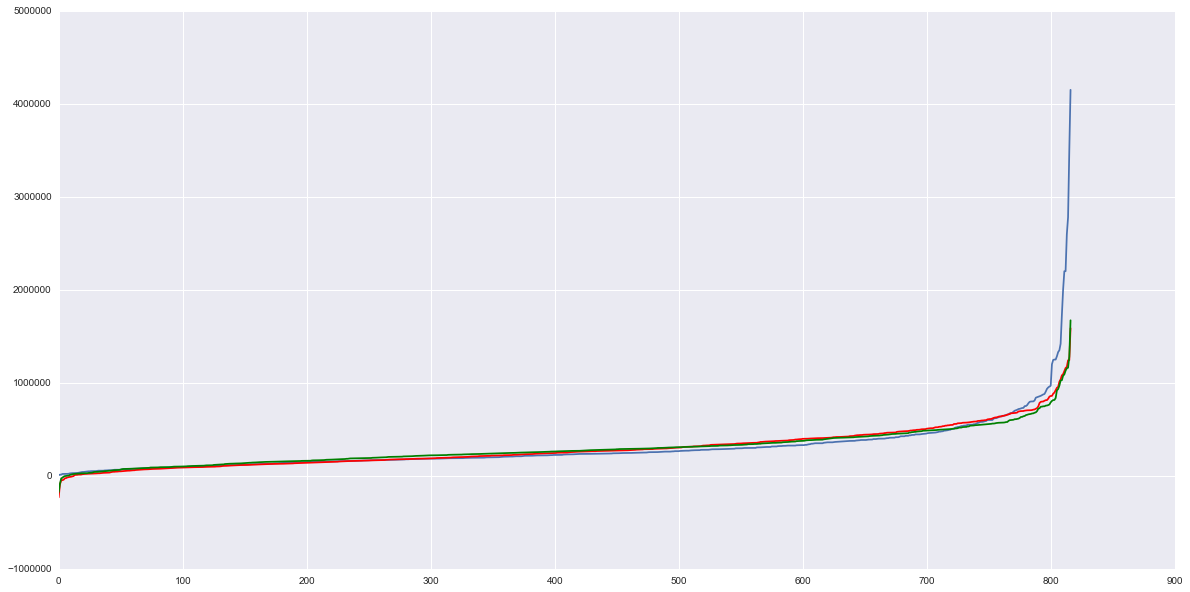

In [35]:
x = np.arange(817)
temp = y_test.sort_values()
plt.figure(figsize=(20,10))
plt.plot(x,temp)
plt.plot(x,linear_predicted_full_df.sort_values(by=['Price']), 'r')
plt.plot(x,linear_predicted_lean_df.sort_values(by=['Price']), 'g')
#from sklearn.metrics import mean_squared_error
#mean_squared_error(y_test, linear_predicted)

In [36]:
from sklearn.linear_model import Ridge
# Create linear regression object
ridge = Ridge(alpha=10)
# Train the model using the training sets and check score
ridge.fit(x_train, y_train)
print(ridge.score(x_train, y_train))
#Equation coefficient and Intercept
print('Coefficient: \n', ridge.coef_)
print('Intercept: \n', ridge.intercept_)
#Predict Output
ridge_predicted_full= ridge.predict(x_test)
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
ridge_predicted_full_df = pd.DataFrame(data=ridge.predict(x_test), columns=['Price'], index=x_test.index)

ridge.fit(x_train_new, y_train)
print(ridge.score(x_train_new, y_train))
#Equation coefficient and Intercept
print('Coefficient: \n', ridge.coef_)
print('Intercept: \n', ridge.intercept_)
#Predict Output
ridge_predicted_lean= ridge.predict(x_test_new)
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
ridge_predicted_lean_df = pd.DataFrame(data=ridge.predict(x_test_new), columns=['Price'], index=x_test.index)

0.525781213784
Coefficient: 
 [  6.30056080e+03   3.72384414e+04   1.17891861e+02  -2.40228212e+01
   2.58993443e+03   9.34994129e+02   2.42099873e+02  -3.48536613e+03
  -6.67892456e+02   5.84489199e+03  -4.39528440e+04  -1.59488672e+04
   1.59488672e+04   1.33880518e+03   8.85571653e+02  -2.22437683e+03
   2.42172659e+04  -2.01175788e+04  -4.09968713e+03   1.34601449e+04
  -9.01836314e+03  -4.44178177e+03  -6.82892076e+04  -4.94077485e+04
  -5.09313503e+04  -2.20277808e+04  -3.44783035e+04  -7.88644401e+03
  -5.94741764e+04   1.95282405e+05  -3.41076125e+04   2.81349581e+04
   7.81835506e+03   9.10667837e+04   1.33893974e+05   1.15565782e+05
  -7.63341024e+03  -3.96985285e+04  -3.19647306e+04  -9.06826199e+04
  -5.60955605e+04  -5.01462844e+03  -5.41956714e+04  -2.55097681e+04
   2.09620112e+05  -5.01385167e+04  -4.14932928e+04  -5.23530185e+04]
Intercept: 
 -562680.677425
0.425890081731
Coefficient: 
 [  6.87437765e+03   4.55927420e+04   1.27771709e+02  -4.74678558e+01
   2.06537669e

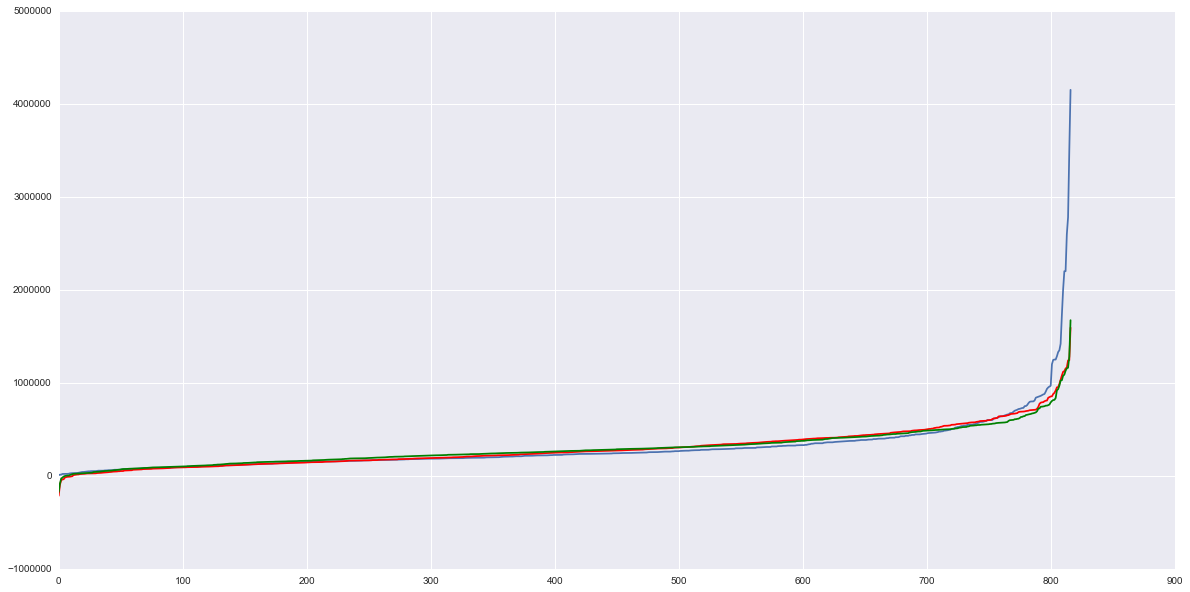

In [37]:
x = np.arange(817)
temp = y_test.sort_values()
plt.figure(figsize=(20,10))
plt.plot(x,temp)
plt.plot(x,ridge_predicted_full_df.sort_values(by=['Price']), 'r')
plt.plot(x,ridge_predicted_lean_df.sort_values(by=['Price']), 'g')

In [38]:
from sklearn import linear_model
# Create lasso regression object
lasso = linear_model.Lasso(alpha=7)
# Train the model using the training sets and check score
lasso.fit(x_train, y_train)
print(lasso.score(x_train, y_train))
#Equation coefficient and Intercept
print('Coefficient: \n', lasso.coef_)
print('Intercept: \n', lasso.intercept_)
#Predict Output
lasso_predicted_full= lasso.predict(x_test)
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
lasso_predicted_full_df = pd.DataFrame(data=lasso.predict(x_test), columns=['Price'], index=x_test.index)

0.526333924752
Coefficient: 
 [  6.47808576e+03   3.71775871e+04   1.16774924e+02  -2.21980489e+01
   2.60443107e+03   9.52925751e+02   2.40669519e+02  -3.05349051e+03
  -7.70623698e+02   5.42730254e+03  -4.47480303e+04  -3.55137305e+04
   0.00000000e+00   1.02389237e+03  -0.00000000e+00  -3.16350985e+03
   2.88289055e+04  -1.63474297e+04   0.00000000e+00   1.76958763e+04
  -3.67270124e+03  -0.00000000e+00  -4.38287245e+04  -1.73993802e+04
  -2.36120214e+04   1.05548388e+04  -1.17249448e+04   2.78718535e+04
  -2.43148347e+04   2.38788887e+05   2.39748613e+03   6.71714355e+04
   4.47817325e+04   1.30422036e+05   1.96322651e+05   1.60157179e+05
   2.58095044e+04  -1.00317624e+04  -5.79502857e+02  -7.29166313e+04
  -3.11069624e+04   2.80430617e+04  -3.71515752e+04   0.00000000e+00
   2.55747829e+05  -1.99729948e+04  -9.59833878e+03  -2.18059272e+04]
Intercept: 
 -585725.516604


In [39]:
lasso.fit(x_train_new, y_train)
print(lasso.score(x_train_new, y_train))
#Equation coefficient and Intercept
print('Coefficient: \n', lasso.coef_)
print('Intercept: \n', lasso.intercept_)
#Predict Output
lasso_predicted_lean= lasso.predict(x_test_new)
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
lasso_predicted_lean_df = pd.DataFrame(data=lasso.predict(x_test_new), columns=['Price'], index=x_test.index)

0.425901014874
Coefficient: 
 [  6.90895683e+03   4.59572243e+04   1.27570597e+02  -4.77241445e+01
   2.06537043e+03   6.97716452e+02   2.80842632e+02  -2.22562838e+03
  -8.00959793e+02   9.05240638e+03  -5.38127498e+04   6.47672165e+02
   1.33694929e+04   4.16969362e+04  -9.08582594e+03   0.00000000e+00
   3.12139659e+04  -8.23509609e+03   0.00000000e+00  -8.14237858e+04
  -3.59042230e+04]
Intercept: 
 -631793.38788


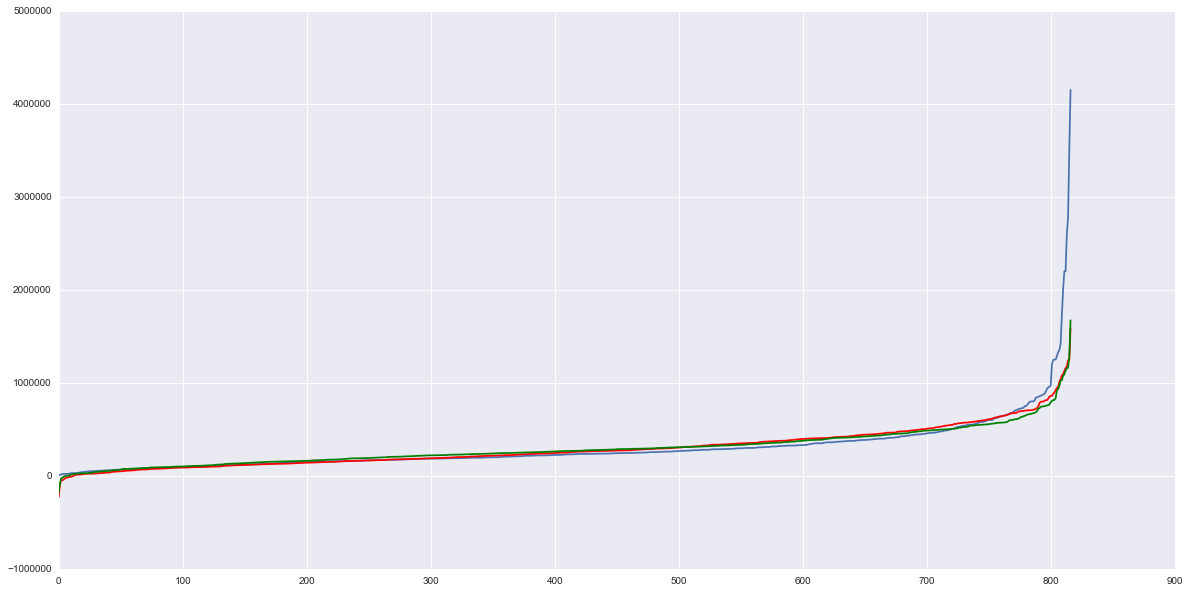

In [40]:
x = np.arange(817)
temp = y_test.sort_values()
plt.figure(figsize=(20,10))
plt.plot(x,temp)
plt.plot(x,lasso_predicted_full_df.sort_values(by=['Price']), 'r')
plt.plot(x,lasso_predicted_lean_df.sort_values(by=['Price']), 'g')

## Evaluating the results

In [41]:
df5 = pd.concat([
    y_test,
    pd.DataFrame(linear_predicted_full_df), 
    pd.DataFrame(ridge_predicted_full_df),
    pd.DataFrame(lasso_predicted_full_df)], 
    axis=1)
df5.columns = ['test','linear','ridge','lasso']
df5.head(10)

,test,linear,ridge,lasso
5376,800000.0,1.092701e+06,1.118167e+06,1.093530e+06
3105,185000.0,4.067068e+05,3.960473e+05,4.065993e+05
2177,130000.0,6.203364e+04,6.466350e+04,6.157954e+04
2416,121000.0,1.311630e+05,1.351028e+05,1.313750e+05
1904,218000.0,1.950272e+05,1.904470e+05,1.948463e+05
2100,195000.0,2.414036e+05,2.463398e+05,2.410340e+05
1593,236250.0,3.497234e+05,3.503639e+05,3.497451e+05
3447,360000.0,3.334474e+05,3.341354e+05,3.333120e+05
1550,179000.0,1.661590e+05,1.663590e+05,1.660796e+05
216,210000.0,2.516449e+05,2.512791e+05,2.514249e+05


In [42]:
df5['lin_mpe'] = ((df5.linear - df5.test)/df5.test)*100
print("Linear mean % error", df5.lin_mpe.mean())
df5['ridge_mpe'] = ((df5.ridge - df5.test)/df5.test)*100
print("Ridge mean % error", df5.ridge_mpe.mean())
df5['lasso_mpe'] = ((df5.lasso - df5.test)/df5.test)*100
print("Lasso mean % error ", df5.lasso_mpe.mean())

Linear mean % error 14.8034647997
Ridge mean % error 15.8201854184
Lasso mean % error  14.8345428099


In [43]:
df_lean = pd.concat([
    y_test,
    pd.DataFrame(linear_predicted_lean_df), 
    pd.DataFrame(ridge_predicted_lean_df),
    pd.DataFrame(lasso_predicted_lean_df)], 
    axis=1)
df_lean.columns = ['test','linear','ridge','lasso']
df_lean.head(10)

,test,linear,ridge,lasso
5376,800000.0,1.281464e+06,1.282278e+06,1.281537e+06
3105,185000.0,2.121346e+05,2.121411e+05,2.121171e+05
2177,130000.0,1.078724e+05,1.080877e+05,1.078710e+05
2416,121000.0,2.498632e+05,2.497814e+05,2.498845e+05
1904,218000.0,1.555362e+05,1.558909e+05,1.555995e+05
2100,195000.0,3.215249e+05,3.212379e+05,3.214709e+05
1593,236250.0,3.623299e+05,3.632418e+05,3.624280e+05
3447,360000.0,3.419384e+05,3.430713e+05,3.419247e+05
1550,179000.0,1.618492e+05,1.618787e+05,1.617996e+05
216,210000.0,3.079284e+05,3.068266e+05,3.078616e+05


In [44]:
df_lean['lin_mpe'] = ((df_lean.linear - df_lean.test)/df_lean.test)*100
print("Linear mean % error", df_lean.lin_mpe.mean())
df_lean['ridge_mpe'] = ((df_lean.ridge - df_lean.test)/df_lean.test)*100
print("Ridge mean % error", df_lean.ridge_mpe.mean())
df_lean['lasso_mpe'] = ((df_lean.lasso - df_lean.test)/df_lean.test)*100
print("Lasso mean % error ", df_lean.lasso_mpe.mean())

Linear mean % error 29.284792941
Ridge mean % error 29.2855632143
Lasso mean % error  29.2965792192


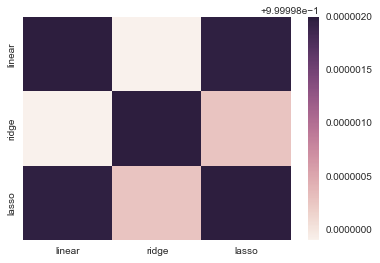

In [85]:
corr = df6.iloc[:,1:4].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [95]:
from sklearn import tree
t = tree.DecisionTreeRegressor(max_depth=500)
t = t.fit(x_train, y_train)
tree_predicted_full = t.predict(x_test)
print(t.score(x_train, y_train))
#Equation coefficient and Intercept
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
tree_predicted_full_df = pd.DataFrame(data=t.predict(x_test), columns=['tree'], index=x_test.index)

0.99999997128


In [96]:
df5['tree'] = tree_predicted_full_df
df5.head()

,test,linear,ridge,lasso,lin_mpe,ridge_mpe,lasso_mpe,tree,tree_mpe,rf,rf_mpe
5373,112000.0,477229.333994,536254.609802,481153.249394,326.097620,378.798759,329.601116,335000.0,134.217857,419813.338072,274.833338
2044,156000.0,111114.249974,114876.904494,106477.305492,-28.772917,-26.360959,-31.745317,250000.0,108.333333,202263.088925,29.655826
5959,40000.0,-5439.279858,18473.694444,-3305.490877,-113.598200,-53.815764,-108.263727,140000.0,190.000000,110772.219449,176.930549
3515,215000.0,245778.456139,249699.732507,245383.878168,14.315561,16.139410,14.132036,220000.0,-27.906977,225654.647697,4.955650
1855,232000.0,233625.662274,232590.777838,233488.142367,0.700716,0.254646,0.641441,225000.0,-28.879310,227796.687951,-1.811772


In [97]:
df5['tree_mpe'] = ((df5['tree'] - df5.test)/df5.test)*100
print("Tree mean % error", df5.tree_mpe.mean())

Tree mean % error 19.6276302531


In [91]:
# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with some parameters.
#rf = RandomForestRegressor(n_estimators=10, max_depth=None, max_features='auto', min_samples_leaf=10, random_state=1)
rf = RandomForestRegressor(max_depth=40, n_estimators=35)
# Fit the model to the data.
rf.fit(x_train, y_train)
# Make predictions.
rf_predicted_full = rf.predict(x_test)
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
rf_predicted_full_df = pd.DataFrame(data=rf.predict(x_test), columns=['rf'], index=x_test.index)

In [92]:
df5['rf'] = rf_predicted_full_df
df5['rf_mpe'] = ((df5['rf'] - df5.test)/df5.test)*100
print("Random Forest mean % error", df5.rf_mpe.mean())

,test,linear,ridge,lasso,lin_mpe,ridge_mpe,lasso_mpe,rf,rf_mpe
5376,800000.0,1.092701e+06,1.118167e+06,1.093530e+06,36.587651,39.770853,36.691207,2.806771e+06,195.747396
3105,185000.0,4.067068e+05,3.960473e+05,4.065993e+05,119.841536,114.079635,119.783397,3.165514e+05,52.658784
2177,130000.0,6.203364e+04,6.466350e+04,6.157954e+04,-52.281813,-50.258847,-52.631120,1.235647e+05,-8.106747
2416,121000.0,1.311630e+05,1.351028e+05,1.313750e+05,8.399205,11.655190,8.574367,1.650686e+05,28.029614
1904,218000.0,1.950272e+05,1.904470e+05,1.948463e+05,-10.537967,-12.639006,-10.620979,1.563177e+05,-26.812118


Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


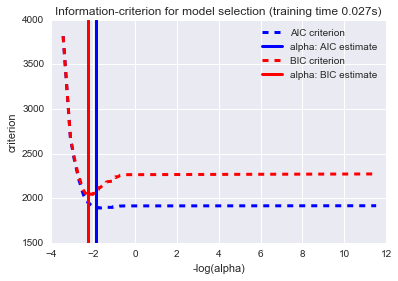

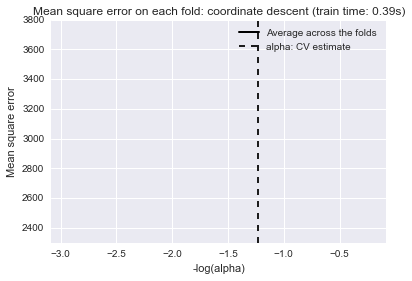

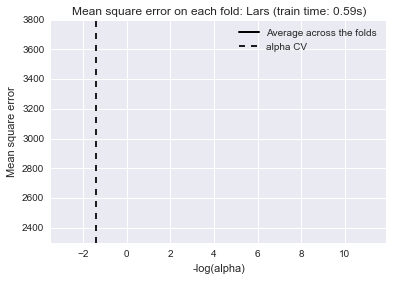

In [20]:
import time
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
#from sklearn import datasets

#X = pd.concat([x_train, x_cv, x_test], axis=1)
#y = pd.concat([y_train, y_cv, y_test], axis=1)

X= x_train
y= y_train

rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

# #############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()

In [18]:
g = x_train.columns.to_series().groupby(x_train.dtypes).groups
g

{dtype('int64'): ['Bedrooms - Total',
  'Baths - Total',
  'DOM',
  'PicCount',
  'Rooms - Total',
  'Basement'],
 dtype('float64'): ['SqFtTotFn',
  'Lot - Acres',
  'Year Built',
  'Total Stories',
  'Garage Capacity',
  'Property Type_Condo',
  'Property Type_Single Family',
  'Flood Zone_No',
  'Flood Zone_Unknown',
  'Flood Zone_Yes',
  'Surveyed_No',
  'Surveyed_Unknown',
  'Surveyed_Yes',
  'Covenants_No',
  'Covenants_Unknown',
  'Covenants_Yes',
  'City_Bethel',
  'City_Canaan',
  'City_Cavendish',
  'City_Cornish',
  'City_Croydon',
  'City_Enfield',
  'City_Grantham',
  'City_Hanover',
  'City_Hartford',
  'City_Hartland',
  'City_Lebanon',
  'City_Ludlow',
  'City_Lyme',
  'City_Norwich',
  'City_Orford',
  'City_Plainfield',
  'City_Plymouth',
  'City_Rochester',
  'City_Royalton',
  'City_Sharon',
  'City_Stockbridge',
  'City_Strafford',
  'City_Sunapee',
  'City_Weathersfield',
  'City_West Windsor',
  'City_Windsor']}

In [95]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC(random_state=0)
svm_model.fit(x_train, y_train)
print(svm_model.coef_)
print(svm_model.intercept_)
svm_predicted_full = svm_model.predict(x_test)
#VERY IMPORTANT TO KEEP THE INDEX!!!!!
svm_predicted_full_df = pd.DataFrame(data=svm_model.predict(x_test), columns=['svm'], index=x_test.index)

[[ -1.07341257e-03  -6.90444000e-04  -4.10686581e-03 ...,   4.07253390e-04
   -2.03838796e-04  -1.82261093e-05]
 [ -3.12226490e-04  -9.16924990e-05  -1.39258951e-04 ...,  -4.20613508e-05
   -2.72911162e-05  -4.08344016e-05]
 [  1.52438420e-05   4.29526294e-05  -1.83086232e-05 ...,  -3.42617385e-05
    3.07358509e-04   2.84421180e-04]
 ..., 
 [ -7.57412133e-05  -4.63918352e-05   1.17721603e-04 ...,  -1.32348898e-23
   -3.25445265e-06   1.32348898e-23]
 [ -2.18510040e-05   1.88263827e-05   1.26531383e-03 ...,   8.27180613e-25
   -1.32348898e-23   0.00000000e+00]
 [ -1.97992947e-05   1.30064992e-04   5.89588137e-06 ...,   4.96308368e-23
    0.00000000e+00  -3.06640721e-06]]
[  2.22178228e-05  -7.59525235e-06  -4.59705999e-05 ...,  -3.00455370e-06
  -2.44599712e-06  -8.25754912e-06]


In [96]:
df5['svm'] = svm_predicted_full_df
df5['svm_mpe'] = ((df5['svm'] - df5.test)/df5.test)*100
print("SVM mean % error", df5.svm_mpe.mean())

SVM mean % error 12.760381027


In [ ]:
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/
http://scikit-learn.org/stable/modules/linear_model.html
    
# to do
1. normalize?
2. use different or more ways of feature selection
http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
3. look into cross validation HW5, to pick model parameters
4. try classification: 
    a. <=3M sale, >3M sale
5. PCA?
6. Year built?s
7. try r^2 metric, ensemble, random cluster forest

You should try to interpret and analyze the computed model parameters and the results 
(why is one better than other for instance).
Before comparing test errors, you can compare (cross) validation errors. 
One thing to check is: did the model with lowest validation error got the lowest test error? 
How far are test errors from validation errors?